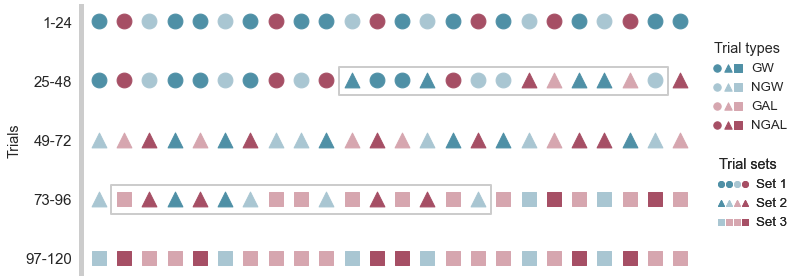

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import dirname
from pandas import read_csv
from itertools import product
from matplotlib.legend_handler import HandlerTuple
sns.set_theme(style='white', context='notebook', font_scale=1.2)
ROOT_DIR = dirname(dirname(dirname(os.path.realpath('__file__'))))
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define plot parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define aesthetics.
order = ['GW', 'NGW', 'GAL', 'NGAL']
palette = sns.diverging_palette(220, 20, n=4).as_hex()
palette = ['#4f90a6', '#a9c6d2', '#d6a6af', '#a64f65']
markers = ['o','^','s']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Initialize canvas.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1, 1, figsize=(10,4))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load sample data.
data = read_csv(os.path.join(ROOT_DIR, 'study02', 'data', 'data.csv')).head(120)

## Restrict to columns of interest.
data = data[['trial','robot','stimulus']]

## Format data.
data['x'] = (data.trial - 1) % 24
data['y'] = (data.trial - 1) // 24
data['third'] = (data.stimulus // 4).astype(int)

## Reorder stimuli IDs. 
replace = {'GW': 0, 'NGW': 1, 'GAL': 2, 'NGAL': 3}
f = lambda x: ''.join(['%0.0f' %x.robot, '%0.0f' %x.stimulus])
data['stimulus'] = np.unique(data.replace(replace).apply(f, 1), return_inverse=True)[-1]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Panel A: Task schematic.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## First loop.
p1 = []
for color, marker in product(palette, markers):
    p = ax.scatter(-99, -99, s=220, color=color, marker=marker)
    p1.append(p)

## Second loop.
p2 = []
for i in np.unique(data.stimulus):
    
    ## Extract current stimulus.
    df = data.query(f'stimulus == {i}')
    
    ## Define aesthetics.
    color = palette[order.index(df.robot.values[0])]
    marker = markers[df.third.values[0]]
    
    ## Plot trials.
    p = ax.scatter(df.x, df.y, s=220, color=color, marker=marker)
    p2.append(p)
            
## Adjust x-axis.
ax.set(xlim=(-0.7,24), xticks=[], xlabel='')

## Adjust y-axis.
ax.set(ylim=(-0.25,4.25), yticks=np.arange(5), ylabel='Trials')
ax.set_yticklabels(['1-24','25-48','49-72','73-96','97-120'], ha='right', fontsize=15)
ax.tick_params(axis='y', which='major', pad=3)
ax.invert_yaxis()

## Define legend (trial types).
l1 = ax.legend(
    handles = [
        tuple(p1[i] for i in np.unique(data.query('robot == "GW"').stimulus)), 
        tuple(p1[i] for i in np.unique(data.query('robot == "NGW"').stimulus)), 
        tuple(p1[i] for i in np.unique(data.query('robot == "GAL"').stimulus)), 
        tuple(p1[i] for i in np.unique(data.query('robot == "NGAL"').stimulus))], 
    labels = ['GW','NGW','GAL','NGAL'], 
    loc = 7,
    frameon = False,
    handler_map = {tuple: HandlerTuple(ndivide=None)},
    bbox_to_anchor=(1.15,0.7), 
    markerscale=0.5,
    title='Trial types'
)

## Define legend (trial sets).
l2 = ax.legend(
    handles = [
        tuple(p2[i] for i in np.unique(data.query('third == 0').stimulus)),
        tuple(p2[i] for i in np.unique(data.query('third == 1').stimulus)),
        tuple(p2[i] for i in np.unique(data.query('third == 2').stimulus))],
    labels = ['Set 1','Set 2','Set 3'], 
    loc = 7,
    frameon = False,
    handler_map = {tuple: HandlerTuple(ndivide=None)},
    bbox_to_anchor=(1.15,0.3), 
    markerscale=0.4,
    title = 'Trial sets',
    prop = {'weight': 'normal'}
)

## Adjust legends.
l1._legend_box.align = "left"
l2._legend_box.align = "left"

## Add legends.
ax.add_artist(l1)
ax.add_artist(l2)

## Add annotations.
# ax.annotate('Start of block', xy=(0, 0), xycoords='data', xytext=(1, 0.6), textcoords='data',
#             ha='left', va='bottom', fontsize=11)
# ax.annotate('', xy=(0, 0.15), xycoords='data', xytext=(0.8, 0.5), textcoords='data',
#             arrowprops=dict(arrowstyle='-[,widthB=0.7', color='k',
#                             connectionstyle="angle3,angleA=0,angleB=90"))

# ax.annotate('1st transition (set 1 ends, set 2 starts)', xy=(0, 0), xycoords='data', 
#             xytext=(11, 1.6), textcoords='data', ha='left', va='bottom', fontsize=11)
# ax.annotate('', xy=(10, 1.15), xycoords='data', xytext=(10.8, 1.5), textcoords='data',
#             arrowprops=dict(arrowstyle='-[,widthB=0.7', color='k',
#                             connectionstyle="angle3,angleA=0,angleB=90"))

# ax.annotate('2nd transition (set 2 ends, set 3 starts)', xy=(0, 0), xycoords='data', 
#             xytext=(2, 3.6), textcoords='data', ha='left', va='bottom', fontsize=11)
# ax.annotate('', xy=(1, 3.15), xycoords='data', xytext=(1.8, 3.5), textcoords='data',
#             arrowprops=dict(color='k', arrowstyle='-[,widthB=0.7',
#                             connectionstyle="angle3,angleA=0,angleB=90"))

## Adjust spines.
sns.despine(left=False, right=True, top=True, bottom=True, ax=ax)
ax.spines['left'].set_linewidth(5); ax.spines['left'].set_color('0.8')

ax.fill_between([9.5, 22.5], 1.25, 0.77, color='none', edgecolor='0.8', capstyle='round', lw=2, zorder=-1)
ax.fill_between([0.5, 15.5], 3.25, 2.77, color='none', edgecolor='0.8', lw=2, zorder=-1)

plt.tight_layout()